<a href="https://colab.research.google.com/github/AlarconGanoza/sphericalAcoustic/blob/master/RIR_interpolation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Regularized spherical Fourier transform for interpolation of RIRs
This Colabs shows the use of the 'spherical Acoustics.py' library for RIR interpolation. This library has functions to perform the regularized spherical Fourier transform as well as additional functions to measure the accuracy of the interpolation. also the own library 'tools.py' was used that contains functions related to the distribution of points in the sphere. The sections of this document are:
1. Clone github repository to the colabs workbench.
2. Load libraries.
3. Load values of the variables from the simulation in Matlab.
4. Design and apply a low pass filter to the initial data.
5. Apply the regularized and unregulated SFT and calculate the interpolation error.
6. Plot the interpolation and energy errors of the impulsive responses. 

## 1. Clone github repository

In [1]:
! git clone 'https://github.com/AlarconGanoza/sphericalAcoustic'

Cloning into 'sphericalAcoustic'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 143 (delta 55), reused 27 (delta 3), pack-reused 0
Receiving objects: 100% (143/143), 109.43 MiB | 17.61 MiB/s, done.
Resolving deltas: 100% (55/55), done.


# 2. Load Libraries

In [6]:
import sys

sys.path.append('/content/sphericalAcoustic/')
fileRIR = '/content/sphericalAcoustic/initialRIR/'

import sphericalAcoustics as sac
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import tools as sat
from tqdm.notebook import tqdm
from scipy.io import savemat, loadmat, whosmat
import ipywidgets as widgets
from scipy import signal
from matplotlib import rc, ticker
 
pi = np.pi

font = {'family' : 'DejaVu Sans', 'weight' : 'normal', 'size' : 12} 
rc('font', **font)
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
 

# 3. Load values of the variables from the simulation in Matlab.



### Available simulations 

In [7]:
!ls /content/sphericalAcoustic/initialRIR/

intercon_example_L16_r8cm.mat  RIR_L16_r8cm_48kHz.mat	RIR_L36_r8cm_48kHz.mat
intercon_example_L25_r8cm.mat  RIR_L25_r16cm_48kHz.mat	RIR_L49_r8cm_16kHz.mat
intercon_example_L36_r8cm.mat  RIR_L25_r24cm_48kHz.mat	RIR_L4_r8cm_48kHz.mat
intercon_example_L49_r8cm.mat  RIR_L25_r8cm_16kHz.mat	RIR_L56_r8cm_16kHz.mat
RIR_L100_r8cm_16kHz.mat        RIR_L25_r8cm_48kHz.mat	RIR_L64_r8cm_16kHz.mat
RIR_L16_r16cm_48kHz.mat        RIR_L36_r16cm_48kHz.mat	RIR_L90_r8cm_16kHz.mat
RIR_L16_r24cm_48kHz.mat        RIR_L36_r24cm_48kHz.mat	RIR_L9_r8cm_48kHz.mat
RIR_L16_r8cm_16kHz.mat	       RIR_L36_r8cm_16kHz.mat


### Select file and load variables


In [23]:
fileName = 'RIR_L100_r8cm_16kHz.mat'
dirFile = fileRIR + fileName
dataMat = loadmat(dirFile)
 
x = dataMat['x']      # Initial sparse distribution
y = dataMat['y']      # Final dense distribution
 
Sa = dataMat['h1']        # Initial simulated data
Starget = dataMat['h2']   # Target simulated data
L = dataMat['L'][0,0]     # Number of points in initial distribution
L2 = np.shape(y)[0]       # Number of points in final distribution
r = dataMat['r'][0,0]     # Radius

Ns = int(dataMat['nsample'])  # Samples number
Fs = float(dataMat['procFs']) # Sampling rate
dt = 1/Fs                     
t = np.arange(0,Ns)*dt*(1e3)  # Time array (ms)      
df = Fs/Ns
f = (1e-3)*np.arange(0,Ns/2 + 1)*df   # Frecuency array (kHz)
N = int(np.floor(np.sqrt(L))-1)       # Maximun order
c = float(dataMat['c'])               # Sound speed
f_max = (c*(np.sqrt(L)-1))/(2*pi*r)   # Frecuency max


# 4. Design and apply a low pass filter

### Butterworth filter design

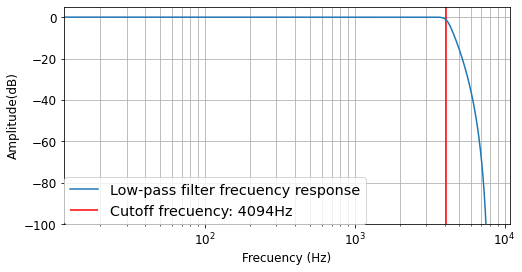

In [9]:
order = 10      # Filter order
nyq = 0.5*Fs    # Frecuencia de nyquist
low = f_max/nyq

b, a = signal.butter(order, low, btype = 'lowpass')
w, h = signal.freqz(b, a)

filt_Sa = signal.filtfilt(b,a,Sa, axis=1);             # Inital filtered data
filt_Starget = signal.filtfilt(b,a,Starget, axis=1);   # Target filtered data

plt.figure(1, figsize = (8,4))
plt.vlines(x=f_max,ymin=-100,ymax=5,colors='r',label='Cutoff frecuency: '+str(int(f_max))+'Hz')
plt.semilogx((Fs/(2*pi))*w,10*np.log10(abs(h)),
  label='Low-pass filter frecuency response')
plt.grid(which='both', axis='both')
plt.legend(loc = (0,0),fontsize ='large')
plt.xlabel('Frecuency (Hz)')
plt.ylim(-100,5)
plt.ylabel('Amplitude(dB)');

# 5. Apply regularized and non-regularized SFT


In [10]:
# SFT non-regularized
filt_Sb0 = np.zeros((L2,Ns))        # Interpolated no regularized data empty array
filt_globalError0 = np.zeros(Ns)    # Global error empty array 

for ii in tqdm(range(Ns)):
  filt_Sb0[:,ii:ii+1] = sac.SFTinterpolation(filt_Sa[:,ii:ii+1],N, x, y, regLambda=0)
  filt_globalError0[ii] = sac.error(filt_Sb0[:,ii:ii+1], filt_Starget[:,ii:ii+1])

# SFT regularized 
regLambda1 = 0.7                       # Lambda value
filt_Sb = np.zeros((L2,Ns))            # Interpolated regularized data empty array
filt_globalError = np.zeros(Ns)        # Global error empty array 

for ii in tqdm(range(Ns)):
  filt_Sb[:,ii:ii+1] = sac.SFTinterpolation(filt_Sa[:,ii:ii+1],N, x, y, regLambda=regLambda1)
  filt_globalError[ii] = sac.error(filt_Sb[:,ii:ii+1], filt_Starget[:,ii:ii+1])

#6. Plot interpolation error and RIRs energy

### Interpolation error


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


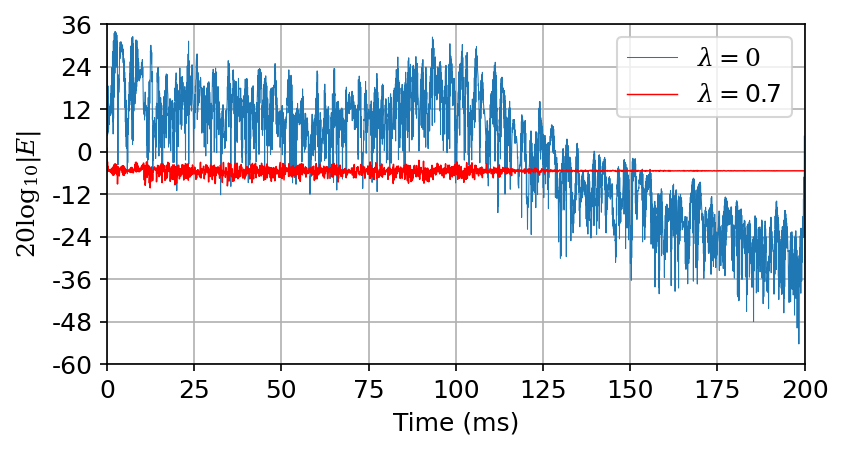

In [13]:
fig, ax0 = plt.subplots(1,1, figsize = (6,3),dpi = 150)
label0 = '$\lambda = 0 $'
label1 = '$\lambda = $'+str(regLambda1)

ax0.plot(t,filt_globalError0, label = label0, linewidth = 0.5, c = 'tab:blue',ls='-');
ax0.plot(t,filt_globalError,label = label1, linewidth = 0.7, c='red');
#ax0.set_title('Global Error (dB) for different values of $\lambda$')


yticksLabel = np.arange(-60,60,12)
ax0.set_yticks(yticksLabel)
ax0.set_yticklabels(yticksLabel)
ax0.set_ylim(-60,36)
ax0.set_xlim(0,200)

ax0.set_ylabel("$20\log_{10}|E|$") 
ax0.set_xlabel("Time (ms)")
ax0.legend(loc = 1);
ax0.grid(True);

fig_name = 'error_L'+str(L) + '.eps'
plt.savefig(fig_name, bbox_inches='tight')

### RIRs Energy

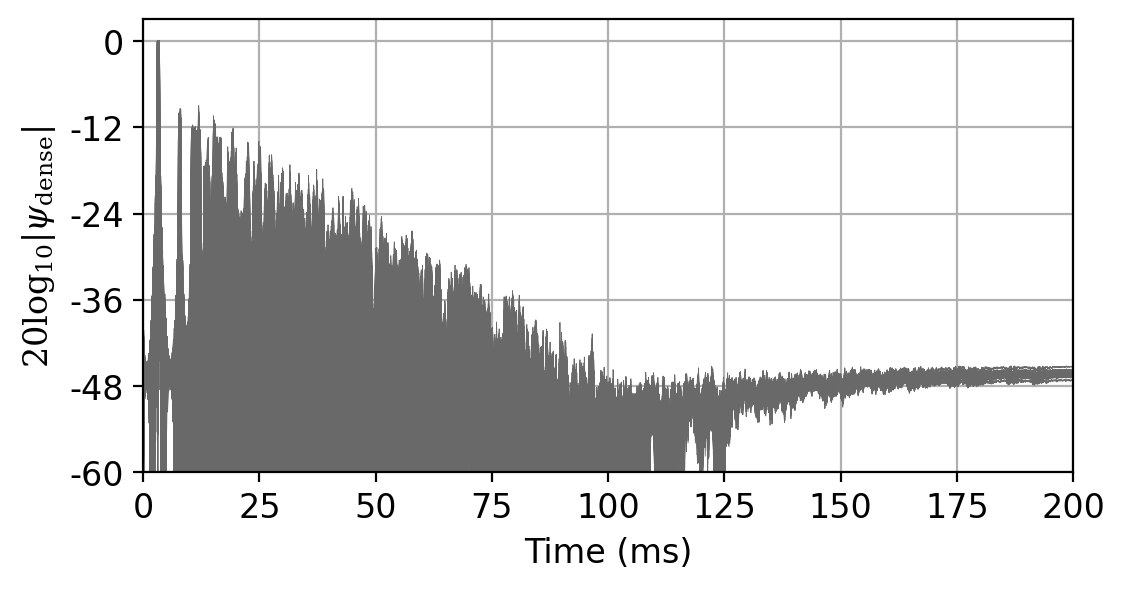

In [14]:
# Target signal
normSb = np.dot(np.diag(1/np.amax(np.abs(filt_Sb), axis = 1)),filt_Sb)
normStarget = np.dot(np.diag(1/np.amax(np.abs(filt_Starget), axis = 1)),filt_Starget)

fig2, ax0 = plt.subplots(1,1, figsize = (6,3),dpi = 200)

ax0.set_ylabel("$20\log_{10}|\psi_{\mathrm{dense}}|$")
ax0.set_xlabel("Time (ms)")
ax0.plot(t,20*np.log10(np.abs(np.transpose(normStarget))), 'dimgray', linewidth='0.3');

xticksLabel = (0,25,50,75,100,125,150, 175, 200)
ax0.set_xticks(xticksLabel)
ax0.set_xticklabels(['0','25','50','75','100','125','150', '175', '200'])
yticksLabel = np.arange(-60,60,12)
ax0.set_yticks(yticksLabel)
ax0.set_yticklabels(yticksLabel)
ax0.set_ylim(-60,3)
ax0.set_xlim(0,200)
ax0.grid(True)
fig_name = 'Energy_L'+str(L) + '_target.png'
fig2.savefig(fig_name, bbox_inches='tight')

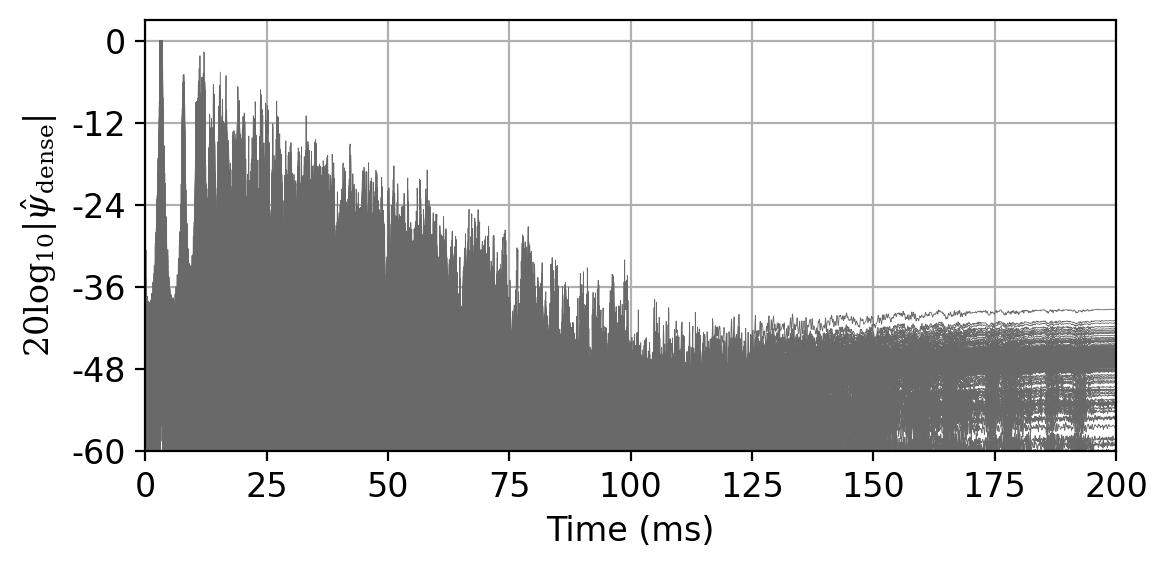

In [ ]:
# Interpolated signal
fig3, ax1 = plt.subplots(1,1, figsize = (6,3),dpi = 200)
ax1.set_ylabel("$20\log_{10}|\hat{\psi}_{\mathrm{dense}}|$")
ax1.set_xlabel("Time (ms)")
ax1.plot(t,20*np.log10(np.abs(np.transpose(normSb))), 'dimgray', linewidth='0.3');
ax1.set_xticks(xticksLabel)
ax1.set_xticklabels(['0','25','50','75','100','125','150', '175', '200'])
ax1.set_yticks(yticksLabel)
ax1.set_yticklabels(yticksLabel)
ax1.set_ylim(-60,3)
ax1.set_xlim(0,200)
ax1.grid(True)
plt.tight_layout()
fig_name = 'Energy_L'+str(L) + '_interpolated.png'
fig3.savefig(fig_name, bbox_inches='tight')
